<a href="https://colab.research.google.com/github/wny-unsw/TumorDifferentiationStageClassification/blob/main/OBSOLETE_TumorDifferentiationStageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [OBSOLETE] NOT USED IN PROJ

## Issue

* SOLVED: reading files from mounted MyDrive brings major overheads. Moving the files into VM beforehand instead. This significantly speed up I/O. ORIGINAL ISSUE: Sometimes, reading images takes very long time. Low I/O throughput significantly bounds the training speed. UPDATE: Tried to use default dataloader but I/O throughtput still low.
* TRAINING FROM SCRATCH: I tried to trained VGG16 on data of 40x magnification, and only got peak validation accuracy of 40%. And then the model overfits. After 92 epoch, it achieves training loss of 0.0198 and training acc of 99.22% with 32.81% Validation acc. Also tried training on 100x data, whose size is around 1000 images. The training process is very slow. Loss came to around 1.30 from 1.34 after 300 epochs.
* WILL USE TRANSFER LEARNING WITH PRETRAINED WEIGHTS.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps
import seaborn as sns
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# from torchvision.io import decode_image
# from torchvision.transforms.v2.functional import to_dtype

In [ ]:
!nvidia-smi

Mon Apr  7 22:57:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import multiprocessing
print(f"Logical CPU cores: {multiprocessing.cpu_count()}")

Logical CPU cores: 2


## Dataset Preparation

In [ ]:
tumor_differentiation_stages = [
    'Adenocarcinoma',
    'High-grade IN',
    'Low-grade IN',
    'Normal',
    'Polyp'
    ]

In [ ]:
def readImgsFromDirectory(_path,_magnification_level = -1):
  image_files = []
  if _magnification_level == -1: #read all level
    for mag in ['40','100','200','400']:
      for stage in tumor_differentiation_stages:
        for _root, _dirs, _files in os.walk(os.path.join(_path,mag,stage)):
          image_files.extend([os.path.join(_root,_file) for _file in _files])
    return image_files
  else:
    for stage in tumor_differentiation_stages:
      for _root, _dirs, _files in os.walk(os.path.join(_path,str(_magnification_level),stage)):
        image_files.extend([os.path.join(_root,_file) for _file in _files])
    return image_files

In [ ]:
image_files = readImgsFromDirectory(
    '/content/drive/MyDrive/ColHis-IDS_restructured_244/ColHis-IDS_restructured_244/',
    100
    )

In [ ]:
df = pd.DataFrame(data=image_files, columns=['image_files'])

In [ ]:
df

image_files
0     /content/drive/MyDrive/ColHis-IDS_restructured...
1     /content/drive/MyDrive/ColHis-IDS_restructured...
2     /content/drive/MyDrive/ColHis-IDS_restructured...
3     /content/drive/MyDrive/ColHis-IDS_restructured...
4     /content/drive/MyDrive/ColHis-IDS_restructured...
...                                                 ...
1833  /content/drive/MyDrive/ColHis-IDS_restructured...
1834  /content/drive/MyDrive/ColHis-IDS_restructured...
1835  /content/drive/MyDrive/ColHis-IDS_restructured...
1836  /content/drive/MyDrive/ColHis-IDS_restructured...
1837  /content/drive/MyDrive/ColHis-IDS_restructured...

[1838 rows x 1 columns]

In [ ]:
def label_image_num(img_path):
    for idx, stage in enumerate(tumor_differentiation_stages):
        if stage in img_path:
            return idx

def label_image(img_path):
    for stage in tumor_differentiation_stages:
        if stage in img_path:
            return stage

In [ ]:
df['label names'] = df['image_files'].copy().map(label_image)
df['labels'] = df['image_files'].copy().map(label_image_num)

<Axes: xlabel='count', ylabel='label names'>

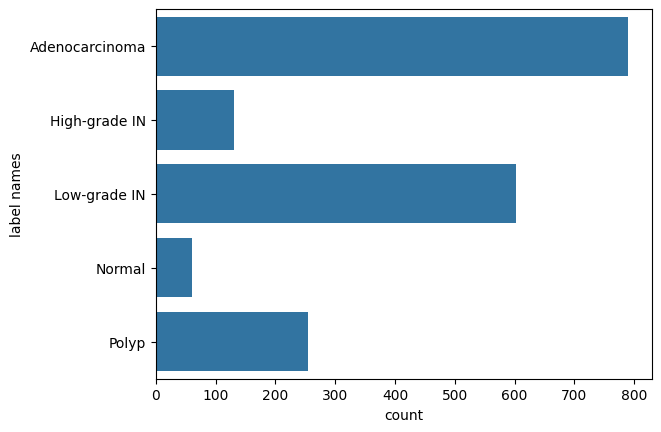

In [ ]:
sns.countplot(y = 'label names', data = df)

## Dataset Visualization

In [ ]:
def plot_fig(label_name, df, nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows, ncols, figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0)
    label_files = df[df['label names']==label_name]['image_files']

    for idx,img_path in enumerate(list(label_files)[:nrows*ncols]):
        img = Image.open(img_path)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(label_name, y=0.94)

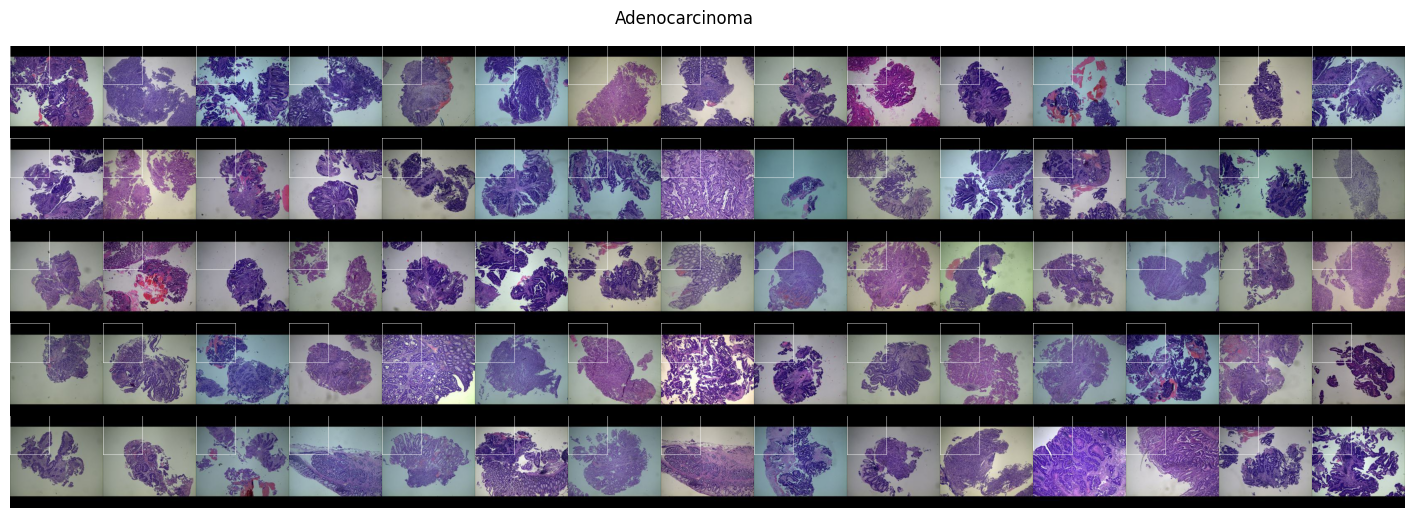

In [ ]:
plot_fig('Adenocarcinoma', df)

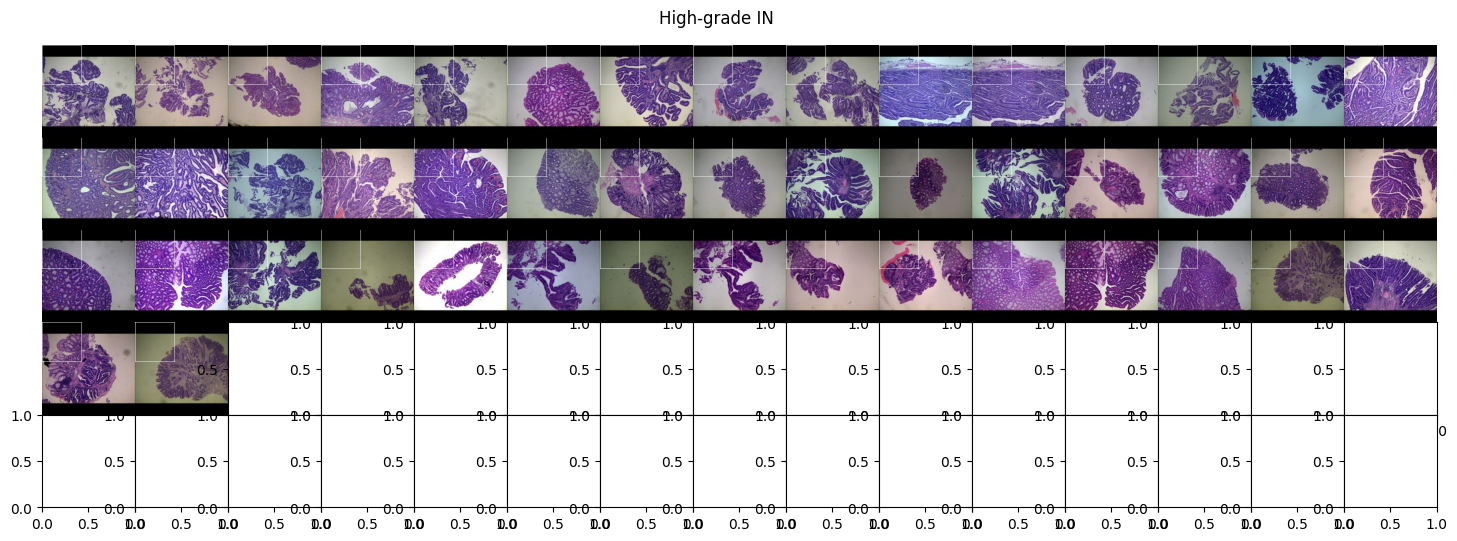

In [ ]:
plot_fig('High-grade IN', df)

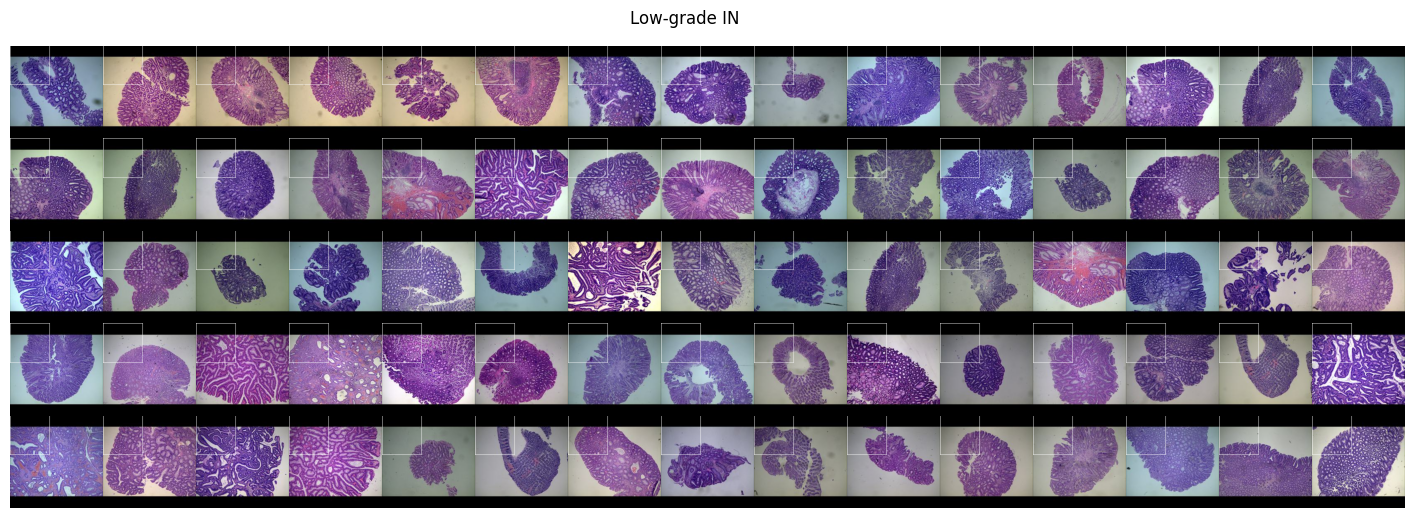

In [ ]:
plot_fig('Low-grade IN', df)

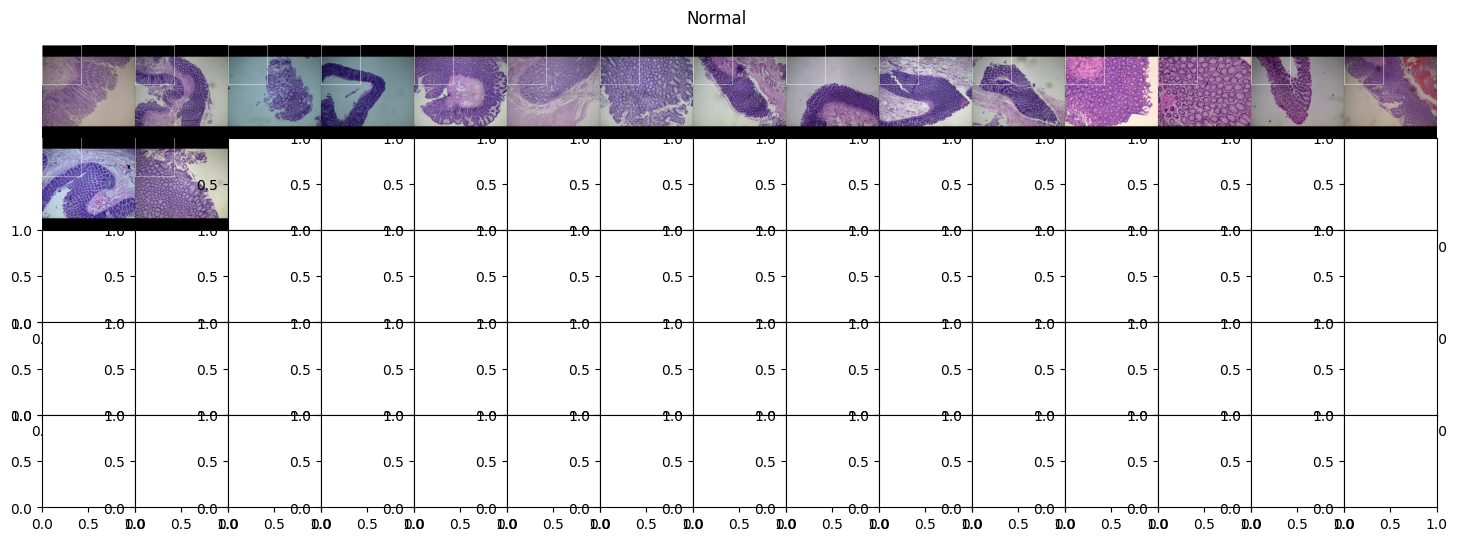

In [ ]:
plot_fig('Normal', df)

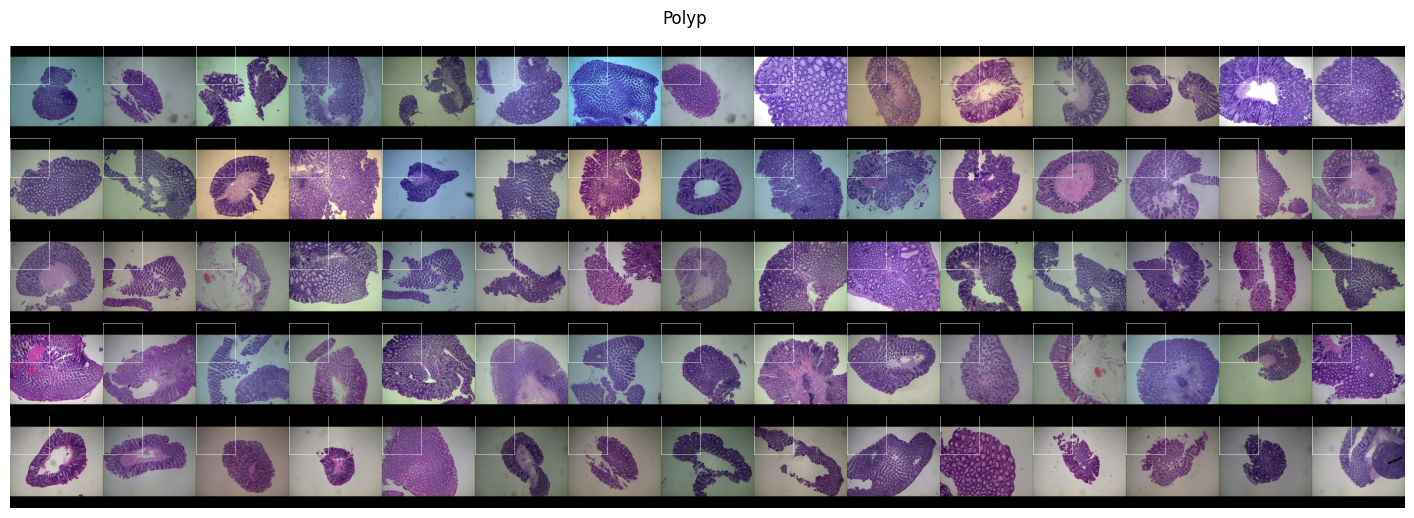

In [ ]:
plot_fig('Polyp',df)

## Creating Pytorch Dataset Object

In [ ]:
X = df['image_files']
y = df['labels']
# train:val:test = .7 .15 .15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
y_train.shape[0], y_val.shape[0], y_test.shape[0], y_train.shape[0]+y_val.shape[0]+y_test.shape[0]

(1286, 276, 276, 1838)

In [ ]:
X_train[:10].tolist(), y_train[:10].tolist()

(['/content/drive/MyDrive/ColHis-IDS_restructured_244/ColHis-IDS_restructured_244/200/Low-grade IN/20210605-XC2014136-1_XC2014136-1-200-002.jpg',
  '/content/drive/MyDrive/ColHis-IDS_restructured_244/ColHis-IDS_restructured_244/200/Adenocarcinoma/20210215-xc2012888-1_xc2012888-1-200-015.jpg',
  '/content/drive/MyDrive/ColHis-IDS_restructured_244/ColHis-IDS_restructured_244/200/Adenocarcinoma/20201120-2014665-4_2014665-4-200-001.jpg',
  '/content/drive/MyDrive/ColHis-IDS_restructured_244/ColHis-IDS_restructured_244/200/Adenocarcinoma/20210605-XC2014131-1_XC2014131-1-200-008.jpg',
  '/content/drive/MyDrive/ColHis-IDS_restructured_244/ColHis-IDS_restructured_244/200/Adenocarcinoma/20210217-xc2013010-1_xc2013010-1-200-003.jpg',
  '/content/drive/MyDrive/ColHis-IDS_restructured_244/ColHis-IDS_restructured_244/200/Adenocarcinoma/20210711-XC2015354-1_XC2015354-1-200-012.jpg',
  '/content/drive/MyDrive/ColHis-IDS_restructured_244/ColHis-IDS_restructured_244/200/Adenocarcinoma/20210711-XC201535

In [ ]:
torch.manual_seed(0)
class pytorch_data(Dataset):
    def __init__(self, img_files, labels, transform):
        # Get Image File Names
        self.full_filenames = img_files.tolist() # get list of images in that directory
        # Get Labels
        self.labels = labels.tolist()  # obtained labels from df
        self.transform = transform
    def __len__(self):
        return len(self.full_filenames) # size of dataset
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        # image = ImageOps.expand(image, (0, 256), fill='black') # Padding to prevent distortion
        image = self.transform(image) # Apply Specific Transformation to Image
        # image = decode_image(self.full_filenames[idx])
        # image = to_dtype(image,scale = True)
        return image, self.labels[idx]

In [ ]:
# define transformation that converts a PIL image into PyTorch tensors
data_transformer = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5))
    ])

In [ ]:
img_dataset_train = pytorch_data(X_train, y_train, data_transformer)
img_dataset_val = pytorch_data(X_val, y_val, data_transformer)
img_dataset_test = pytorch_data(X_test, y_test, data_transformer)

In [ ]:
# Training DataLoader
train_dataloader = DataLoader(
    img_dataset_train,
    batch_size=64,
    shuffle=True,
    # num_workers=2,
    pin_memory=True,
    drop_last=True
    )

# Validation DataLoader
val_dataloader = DataLoader(
    img_dataset_val,
    batch_size=64,
    shuffle=False,
    # num_workers=2,
    pin_memory=True,
    drop_last=True
    )

'''It is generally not recommended to return CUDA tensors in multi-process loading
because of many subtleties in using CUDA and sharing CUDA tensors in multiprocessing (see CUDA in multiprocessing).
Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True),
which enables fast data transfer to CUDA-enabled GPUs.
https://pytorch.org/docs/stable/data.html#multi-process-data-loading
'''

In [ ]:
# # check dataloader
# x, y = next(iter(train_dataloader))
# print(f'imgs shape: {x.shape}\n\nlabels: {y}')

## VGG16

In [ ]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
  def __init__(self, num_classes=1000):
    super(VGG16, self).__init__()
    self.features = nn.Sequential(
      # Conv Block 1
      nn.Conv2d(3, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Conv Block 2
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Conv Block 3
      nn.Conv2d(128, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Conv Block 4
      nn.Conv2d(256, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Conv Block 5
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(512, 512, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Linear(512*7*7, 4096),
      nn.ReLU(True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(True),
      nn.Dropout(),
      nn.Linear(4096, num_classes)
    )
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

## Training

In [ ]:
# Params
# batch_size = 32
learning_rate = 0.001
num_epochs = 30

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16 = VGG16(num_classes=5).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate)

In [ ]:
summary(vgg16, input_size=(3, 224, 224),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# vgg16.load_state_dict(torch.load('/content/drive/MyDrive/Models/vgg16_EBHI_mag_100_weights.pth',map_location=device))

In [ ]:
for epoch in range(num_epochs):
  # Train
  vgg16.train()
  running_loss = 0.0
  correct = 0
  total = 0
  for images,labels in train_dataloader:
    images,labels = images.to(device),labels.to(device)
    outputs = vgg16(images) # Forward
    loss = criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward() # Backward

    optimizer.step()
    # Track statistics
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total+=labels.size(0)
    correct+=(predicted == labels).sum().item()
  avg_loss = running_loss / len(train_dataloader)
  accuracy = 100 * correct / total
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

  # Validation
  vgg16.eval()  # Set model to evaluation mode
  correct = 0
  total = 0
  with torch.no_grad():  # No need to compute gradients during validation
    for inputs, labels in val_dataloader:
      images,labels = images.to(device),labels.to(device)
      outputs = vgg16(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      # correct += (predicted[:labels.size(0)] == labels).sum().item()
      correct += (predicted == labels).sum().item()
  val_accuracy = 100 * correct / total
  print(f"Validation Accuracy: {val_accuracy:.2f}%\n")

KeyboardInterrupt: 

In [ ]:
# torch.save(vgg16.state_dict(), './drive/MyDrive/Models/vgg16_EBHI_mag_100_weights.pth')